In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt

## Fetching the Data 

This is a bit annoying. But to download from kaggle we need to upload the kaggle API key here. Then we need to move the file to the correct folder after which we need to change the permissions. The error messages will not provide super helpful information so I've added the correct code here. 

You can also upload the dataset from kaggle manually or you can download all of this locally. The kaggle dataset can be found [here](https://www.kaggle.com/therohk/million-headlines).

Then again, this code works;

In [0]:
# from google.colab import files
# files.upload()

In [0]:
ls

kaggle.json  sample_data/


In [0]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d therohk/million-headlines

 44% 9.00M/20.2M [00:01<00:01, 7.25MB/s]
100% 20.2M/20.2M [00:01<00:00, 13.5MB/s]


The idea is to build something like this; 

```
word_i -> together <- word_j 
```

We will merely predict if these two words share context. In my book they will share context if they are in the same title. Later we will try to construct document embeddings as well.

## Sequence of Letters 

Let's now take these headlines and grab sequences of letters out of them.

In [0]:
import pandas as pd
import itertools as it 
from collections import Counter 
from functools import reduce 

n_documents = 20000

headlines = pd.read_csv('million-headlines.zip')['headline_text'][:n_documents]

In [0]:
headlines

0        aba decides against community broadcasting lic...
1           act fire witnesses must be aware of defamation
2           a g calls for infrastructure protection summit
3                 air nz staff in aust strike for pay rise
4            air nz strike to affect australian travellers
                               ...                        
19995            australian coach leaves french club brive
19996    australia will always be an al qaeda target ex...
19997     beattie praises federal govts environment effort
19998             blackout cause still under investigation
19999                boost planned for central vic tourism
Name: headline_text, Length: 20000, dtype: object

The next codeblock looks strange but it is much faster to split the counters up.

In [0]:
import tqdm

combs = []
bunchsize = 500
for i in tqdm.tqdm(range(round(n_documents/bunchsize))):
  g = (Counter(it.combinations(i.split(" "), 2)) for i in headlines[bunchsize*i:bunchsize*(i+1)])
  combs.append(reduce(lambda x,y : x + y, g))

100%|██████████| 40/40 [00:40<00:00,  1.01s/it]


In [0]:
big_word_count = reduce(lambda x,y : x + y, combs)

In [0]:
word_count = Counter([i[0] for i in big_word_count.keys()]) + Counter([i[1] for i in big_word_count.keys()])
uniq_words = Counter(word_count.keys()).keys()
num_words = len(uniq_words)

In [0]:
m = {c: i for i, c in enumerate(uniq_words)}

def gen_rand_tok(n):
  t1 = np.random.choice(list(word_count.keys()), size=n, replace=True)
  t2 = np.random.choice(list(word_count.keys()), size=n, replace=True)
  return np.array([[m[w1], m[w2]] for w1, w2 in zip(t1, t2) if (w1, w2) not in big_word_count.keys()])

This is where we generate the training labels. 

In [0]:
positive_integers = np.array([[m[w1], m[w2]] for w1, w2 in big_word_count.keys()])
negative_integers = gen_rand_tok(n=positive_integers.shape[0])

integers_in = np.concatenate([positive_integers, negative_integers])
labels_in = np.concatenate([list(big_word_count.values()), np.zeros(negative_integers.shape[0])])

In [0]:
from tensorflow.keras.layers import Embedding, Dense, Flatten, Input, Dot
from tensorflow.keras.models import Sequential, Model

dim_words = 5

# this one is so we might grab the embeddings
model_emb = Sequential()
embedding = Embedding(num_words, dim_words, input_length=1)
model_emb.add(embedding)
model_emb.add(Flatten())

word_one = Input(shape=(1,))
word_two = Input(shape=(1,))

cross_prod = Dot(axes=1)([model_emb(word_one), model_emb(word_two)])
out = Dense(1, activation="relu")(cross_prod)

glovelike = Model(inputs=[word_one, word_two], outputs=out)

In [0]:
from tensorflow.keras.optimizers import Adam

In [0]:
for lr, epo in zip([0.02, 0.01, 0.002], [5, 10, 10]):
  print(f"stepsize={lr}")
  adam = Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, amsgrad=False)
  glovelike.compile(adam, 'mse', metrics=['accuracy'])
  glovelike.fit(x=[integers_in[:, 0], integers_in[:, 1]], y=labels_in, epochs=epo, verbose=1)

stepsize=0.02
Train on 514741 samples
Epoch 1/5
514741/514741 [==============================] - 33s 65us/sample - loss: 3.9293 - accuracy: 0.4297
Epoch 2/5
514741/514741 [==============================] - 33s 64us/sample - loss: 3.9356 - accuracy: 0.4379
Epoch 3/5
514741/514741 [==============================] - 33s 64us/sample - loss: 3.9519 - accuracy: 0.4420
Epoch 4/5
514741/514741 [==============================] - 33s 65us/sample - loss: 3.7523 - accuracy: 0.5104
Epoch 5/5
514741/514741 [==============================] - 34s 66us/sample - loss: 3.4820 - accuracy: 0.5214
stepsize=0.01
Train on 514741 samples
Epoch 1/10
514741/514741 [==============================] - 33s 65us/sample - loss: 3.1277 - accuracy: 0.5090
Epoch 2/10
514741/514741 [==============================] - 33s 64us/sample - loss: 3.0049 - accuracy: 0.5079
Epoch 3/10
514741/514741 [==============================] - 33s 64us/sample - loss: 2.9321 - accuracy: 0.5064
Epoch 4/10
514741/514741 [=======================

In [0]:
# for i in range(100, 200):
#   print(headlines[i])

In [0]:
words = ['violence', 'arrested', 'murder', 'police', 'jury', 'minister', 'health', 'finance', 'banks', 'wildlife', 'doctor',]
emb = model_emb.predict([m[i] for i in words])

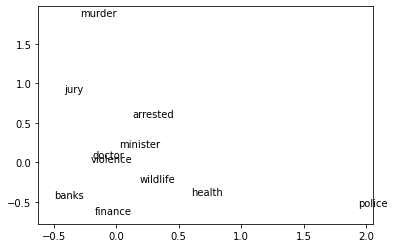

In [0]:
plt.scatter(emb[:, 0], emb[:, 1], alpha=0)
for i, w in enumerate(words):
  plt.text(emb[i, 0], emb[i, 1], w)

## Cosine Distances 

Let's compare some of these distances now.

In [0]:
from scipy.spatial import distance
import pandas as pd

In [0]:
df = pd.DataFrame(distance.cdist(emb, emb, 'cosine'), columns=words)
df.index = words
q1, q2 = df.quantile([0.2, 0.8]).mean(axis=1).values

def color(val):
    if val < q1:
        color = 'green'
    elif val > q2:
        color = 'red'
    else:
        color = 'yellow'
    return 'background-color: %s' % color

df.style.applymap(color)

,violence,arrested,murder,police,jury,minister,health,finance,banks,wildlife,doctor
violence,1.11022e-16,0.285876,0.552401,0.740434,0.390006,0.23072,0.365055,0.358957,0.287255,1.11932,0.110101
arrested,0.285876,0,0.428449,0.681302,0.414277,0.497916,0.72541,0.810825,0.884904,1.41193,0.57325
murder,0.552401,0.428449,2.22045e-16,0.669706,0.699238,0.637022,0.756667,1.1425,0.912604,1.44829,0.732822
police,0.740434,0.681302,0.669706,0,0.956971,0.483625,0.411586,0.73214,0.754237,0.725193,0.823263
jury,0.390006,0.414277,0.699238,0.956971,0,0.5441,0.976383,0.842402,0.733509,1.1961,0.414412
minister,0.23072,0.497916,0.637022,0.483625,0.5441,0,0.237878,0.327957,0.345182,0.567058,0.127875
health,0.365055,0.72541,0.756667,0.411586,0.976383,0.237878,1.11022e-16,0.415829,0.404105,0.674157,0.327089
finance,0.358957,0.810825,1.1425,0.73214,0.842402,0.327957,0.415829,0,0.196942,0.562335,0.289592
banks,0.287255,0.884904,0.912604,0.754237,0.733509,0.345182,0.404105,0.196942,1.11022e-16,0.674767,0.189577
wildlife,1.11932,1.41193,1.44829,0.725193,1.1961,0.567058,0.674157,0.562335,0.674767,1.11022e-16,0.755799


## Euclidean Distances 

Let's also have a peek at another type of distance.

In [0]:
df = pd.DataFrame(distance.cdist(emb, emb, 'euclidean'), columns=words)
df.index = words
q1, q2 = df.quantile([0.2, 0.8]).mean(axis=1).values
df.style.applymap(color)

,violence,arrested,murder,police,jury,minister,health,finance,banks,wildlife,doctor
violence,0,1.45973,3.70162,6.16098,1.36555,0.900202,1.51025,1.04518,0.919091,2.26418,0.56765
arrested,1.45973,0,3.36521,6.03374,1.74203,1.81458,2.41928,2.18763,2.25129,3.20513,1.87947
murder,3.70162,3.36521,0,6.32765,3.92679,3.80989,4.07904,4.4302,4.15313,5.11645,3.93883
police,6.16098,6.03374,6.32765,0,6.51848,5.77523,5.44957,6.15187,6.18255,6.1205,6.26537
jury,1.36555,1.74203,3.92679,6.51848,0,1.63207,2.56273,1.93462,1.79403,2.67092,1.38742
minister,0.900202,1.81458,3.80989,5.77523,1.63207,0,1.27041,1.0638,1.07792,1.6955,0.679272
health,1.51025,2.41928,4.07904,5.44957,2.56273,1.27041,0,1.58871,1.56992,2.15724,1.45807
finance,1.04518,2.18763,4.4302,6.15187,1.93462,1.0638,1.58871,0,0.754245,1.63831,0.899229
banks,0.919091,2.25129,4.15313,6.18255,1.79403,1.07792,1.56992,0.754245,0,1.76234,0.711037
wildlife,2.26418,3.20513,5.11645,6.1205,2.67092,1.6955,2.15724,1.63831,1.76234,0,1.83593


Why is `arrested` so different from `murder`? It feels like they should be similar. 

Let's find out.

In [0]:
n_arrested = (headlines.loc[lambda d: d.str.contains('arrested')].shape)
n_murder = (headlines.loc[lambda d: d.str.contains('murder')].shape)

n_both = (headlines
          .loc[lambda d: d.str.contains('arrested')]
          .loc[lambda d: d.str.contains('murder')]
          .shape)

n_arrested, n_murder, n_both

((56,), (172,), (2,))

And what about `money`, `cash`, `zealand` and `domestic`?

In [0]:
n_arrested = (headlines.loc[lambda d: d.str.contains('money')].shape)
n_murder = (headlines.loc[lambda d: d.str.contains('zealand')].shape)

n_both = (headlines
          .loc[lambda d: d.str.contains('money')]
          .loc[lambda d: d.str.contains('zealand')]
          .shape)

n_arrested, n_murder, n_both

((27,), (24,), (0,))

Note how there is no overlap! 

## Conclusion 

Notice the tricky business here with word embeddings. They depend on a lot of things; 

- the size of the embeddig $k$ 
- the choice of algorithm 
- the choice of the data going in 

We need to be careful that we don't cherry pick our results. The output of the model may not generalise the language well if we pick a bad language task, a bad dataset or if the hyperparameters of the model are wrong. 

The hope though is that if you train on a large corpus you do get something that might be general. It's not always the case though that a word embedding that is general will be appropriate for the virtual assistant setting.

## In Real Life

You won't need to train these yourself. In fact, it's I'll advised. Best to use the ones trained by others. 
